In [65]:
import os
from PIL import Image, ImageOps
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
def plot_samples(inputs, outputs, outputNames, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(inputs[i])  # Nu specifica cmap pentru a păstra culorile originale
        ax.set_title(f"Label: {outputNames[outputs[i]]}")

    plt.show()

def load_images_from_folders(normalized_folder, sepia_folder):
    inputs = []
    outputs = []
    outputNames = ['normalized', 'sepia']
    # Normlizate
    for filename in os.listdir(normalized_folder):
        if filename.endswith('.jpg') and 'normalized' in filename:
            img = Image.open(os.path.join(normalized_folder, filename)).resize((8, 8)).convert('L') # gri

            inputs.append(np.array(img_array))
            outputs.append(0)  # Eticheta pentru imagini normalizate

    # Sepia
    for filename in os.listdir(sepia_folder):
        if filename.endswith('.jpg') and 'sepia' in filename:
            img = Image.open(os.path.join(sepia_folder, filename)).resize((8, 8)).convert('L') # gri
            
            img_array = np.array(img) / 16.0
            inputs.append(np.array(img_array))
            outputs.append(1)  # Eticheta pentru imagini cu sepia


    noData = len(inputs)
    permutation = np.random.permutation(noData)
    inputs = np.array(inputs)[permutation]
    outputs = np.array(outputs)[permutation]
    
    return inputs, outputs, outputNames

normalized_folder = 'D:/FACULTATE/SEM4/AI/Lab7/img_normalizate'
sepia_folder = 'D:/FACULTATE/SEM4/AI/Lab7/img_sepia'

inputs_data, outputs_data, outputNames = load_images_from_folders(normalized_folder, sepia_folder)

def flatten(mat):
    x = []
    for line in mat:
        for el in line:
            x.append(el)
    return x

In [10]:
def plot_confusion_matrix_v2(cm, class_names, title):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    text_format = '.2f'  # Setarea formatului de afișare pentru valorile din matricea de confuzie
    thresh = cm.max() / 2.
    for row, column in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(column, row, format(cm[row, column], text_format),
                 horizontalalignment='center',
                 color='white' if cm[row, column] > thresh else 'black')
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [87]:
class Model:
    def __init__(self, input_size, output_size, hidden_units=32):
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_units = hidden_units
        
        np.random.seed(42)
        self.W1 = np.random.randn(input_size, hidden_units) / np.sqrt(input_size)
        self.b1 = np.zeros((1, hidden_units))
        self.W2 = np.random.randn(hidden_units, output_size) / np.sqrt(hidden_units)
        self.b2 = np.zeros((1, output_size))
    
    # relu : daca valoarea e mai mica decat 0 o face egata cu 0
    #       daca valoarea este mai mare decat 0 ramane neschimbata
    def relu(self, x):
        return np.maximum(0, x)

    # Folosita in ultimul strat
    def softmax(self, x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)


    def cross_entropy_loss(self, predictions, targets):
        num_examples = targets.shape[0]
        log_likelihood = -np.log(predictions[range(num_examples), targets])
        return np.sum(log_likelihood) / num_examples

    def evaluate(self, X, y):
        num_examples = X.shape[0]

        z1 = np.dot(X, self.W1) + self.b1
        a1 = self.relu(z1)
        z2 = np.dot(a1, self.W2) + self.b2
        probs = self.softmax(z2)

        
        predictions = np.argmax(probs, axis=1)
        accuracy = np.mean(predictions == y)
        confusion_matrix = np.zeros((len(np.unique(y)), len(np.unique(y))))
        
        for i in range(len(y)):
            confusion_matrix[y[i], predictions[i]] += 1
        return accuracy, confusion_matrix

    
    def forward(self, X_train):
        trainInputs_flat = np.array([x.flatten() for x in X_train])
        
        # produs scalar (date intrare + ponderea W1)
        z1 = np.dot(trainInputs_flat, self.W1) + self.b1
        # max (0, z1)
        a1 = self.relu(z1)
         # produs scalar (activarile h-layers + ponderea W2)
        z2 = np.dot(a1, self.W2) + self.b2
        # scoate vector de probs
        probs = self.softmax(z2)
        
        return trainInputs_flat, z1, a1, z2, probs

    def backward(self, trainInputs_flat, a1, probs, testInputs, num_examples):
        err = probs
        # interpretat ca o formă de "one-hot encoding" a claselor și 
        # actualizarea erorii în conformitate cu diferența dintre probabilitatea prezisă 
        # și 1 (dacă clasa reală este prezisă) sau 0 (dacă clasa reală nu este prezisă).
        err[range(num_examples), testInputs] -= 1
        # normalizare eroare
        err /= num_examples

        #produsul scalar (output h-layers si err)
        dW2 = np.dot(a1.T, err)
        # se calculeaza bias ul pentru stratul de iesire (gradientul)
        db2 = np.sum(err, axis=0, keepdims=True)

        #TO_SEARCH:
        # produsul scalar 
        delta2 = np.dot(err, self.W2.T) * (a1 > 0)
        dW1 = np.dot(trainInputs_flat.T, delta2)
        db1 = np.sum(delta2, axis=0)
        return dW1, db1, dW2, db2

    def optimizer(self, dW1, db1, dW2, db2, learning_rate):
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        
    def train(self, X_train, testInputs, learning_rate, num_epochs):
        #X_train.shape[0] = 1636
        num_examples, _, _ = X_train.shape
        losses = []
        for epoch in range(num_epochs):
            trainInputs_flat, z1, a1, z2, probs = self.forward(X_train)
            
            loss = self.cross_entropy_loss(probs, testInputs)
            losses.append(loss)
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")
            
            dW1, db1, dW2, db2 = self.backward(trainInputs_flat, a1, probs, testInputs, num_examples)
            
            self.optimizer(dW1, db1, dW2, db2, learning_rate)
        return self.W1, self.b1, self.W2, self.b2, losses


1636
Epoch 0, Loss: 5.139034958644271
Epoch 100, Loss: 0.5759888474837312
Epoch 200, Loss: 0.5569580168899033
Epoch 300, Loss: 0.5461344203376995
Epoch 400, Loss: 0.5378923870182084
Epoch 500, Loss: 0.5325589145238848
Epoch 600, Loss: 0.5250415317394502
Epoch 700, Loss: 0.5170371316647704
Epoch 800, Loss: 0.5123323538779008
Epoch 900, Loss: 0.5067750023170142
Acuratețe: 0.6878048780487804


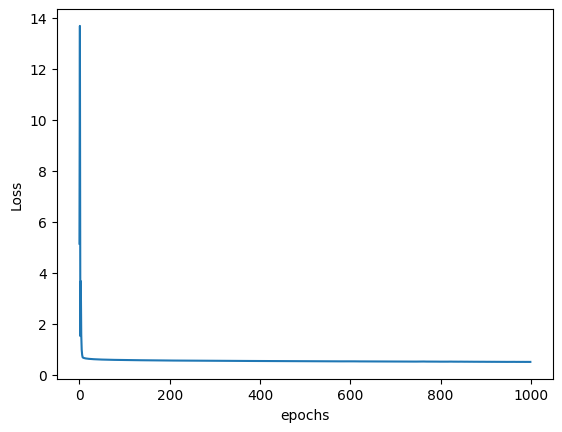

<Figure size 800x600 with 0 Axes>

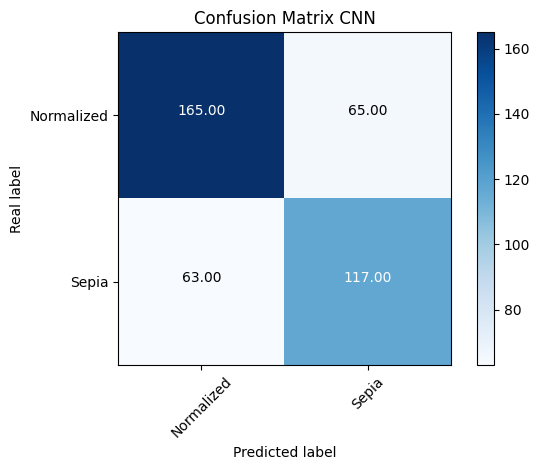

In [86]:
trainInputs, trainOutputs, testInputs, testOutputs = train_test_split(inputs_data, outputs_data, test_size=0.2, random_state=42)


# MODEL
input_size = trainInputs.shape[1] * trainInputs.shape[2]  # Numărul de pixeli
num_classes = len(np.unique(testInputs))  # Numărul "labels" in cazul meu (2 - 0 si 1)
learning_rate = 0.01
epochs = 1000
model = Model(input_size, num_classes)

W1, b1, W2, b2, losses = model.train(trainInputs, testInputs, learning_rate, epochs)


trainOutputs = np.array([x.flatten() for x in trainOutputs])
accuracy, confusion_matrix = model.evaluate(trainOutputs, testOutputs)
print("Acuratețe:", accuracy)


plt.plot(range(epochs), losses)
plt.ylabel("Loss")
plt.xlabel("epochs")


plt.figure(figsize=(8, 6))
outputNames = ["Normalized", "Sepia"]
plot_confusion_matrix_v2(confusion_matrix, outputNames, "CNN")
plt.show()